In [1]:
import copy
import logging
import os
from typing import Any, Dict, Tuple, Union

import numpy as np
import pandas as pd
import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback
import optuna.logging
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import statsmodels.api as sm
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader

from pytorch_forecasting.metrics import LogNormalDistributionLoss
from pytorch_forecasting import DeepAR

optuna_logger = logging.getLogger("optuna")
pl.seed_everything(666)

class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

def optimize_hyperparameters(
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        model_path: str,
        max_epochs: int = 100,
        n_trials: int = 100,
        timeout: float = 3600 * 10.0,  # 10 hours
        gradient_clip_val_range: Tuple[float, float] = (0.1, 0.5),
        hidden_size_range: Tuple[int, int] = (32, 256),
        learning_rate_range: Tuple[float, float] = (1e-3, 1e-2),
        rnn_layers_range : Tuple[int, int] = (2, 4),
        trainer_kwargs: Dict[str, Any] = {},
        log_dir: str = "lightning_logs",
        study: optuna.Study = None,
        verbose: Union[int, bool] = None,
        pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
        **kwargs,
) -> optuna.Study:

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    loss = kwargs.get(
        "loss", LogNormalDistributionLoss()
    )

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint.
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), filename="{epoch}", monitor="val_loss"
        )

        # The default logger in PyTorch Lightning writes to event files to be consumed by
        # TensorBoard. We don't use any logger here as it requires us to implement several abstract
        # methods. Instead we setup a simple callback, that saves metrics from each validation step.
        metrics_callback = MetricsCallback()
        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        early_stop_callback = EarlyStopping(
            monitor='val_loss',
            min_delta=1e-4,
            patience=10,
            verbose=False,
            mode='min'
        )
        default_trainer_kwargs = dict(
            gpus=[0] if torch.cuda.is_available() else None,
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                metrics_callback,
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                early_stop_callback
            ],
            logger=logger,
            limit_train_batches=40,
        )
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(
            **default_trainer_kwargs,
        )

        # create model
        hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
        rnn_layers = trial.suggest_int('rnn_layers', *rnn_layers_range, log=True)
        kwargs["loss"] = copy.deepcopy(loss)
        model = DeepAR.from_dataset(
            train_dataloader.dataset,
            hidden_size=hidden_size,
            rnn_layers=rnn_layers,
            **kwargs,
        )
        # find good learning rate
        model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        # fit
        trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

        # report result
        return metrics_callback.metrics[-1]["val_loss"].item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study

Global seed set to 666


In [2]:
import pandas as pd

def split_dataframe(
        data: pd.DataFrame,
        train: float = 0.7,
        val: float = 0.2,
        test: float = 0.1
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    hours_range = pd.date_range(
        start=data.loc[:, 'ds'].min(),
        end=data.loc[:, 'ds'].max(),
        freq='H'
    )
    num_hours = hours_range.size
    test_data = pd.DataFrame()

    if test:
        train_data = data.loc[
            data['ds'] < hours_range[int(train*num_hours)],
            :
        ]
        val_data = data.loc[
            (data['ds'] >= hours_range[int(train*num_hours)]) &
            (data['ds'] < hours_range[int((train+val)*num_hours)]),
            :
        ]
        test_data = data.loc[
            data['ds'] >= hours_range[int((train+val)*num_hours)],
            :
        ]
    else:
        train_data = data.loc[
             data['ds'] < hours_range[int(train*num_hours)],
             :
        ]
        val_data = data.loc[
           (data['ds'] >= hours_range[int(train*num_hours)]),
           :
        ]
    return train_data, val_data, test_data

In [3]:
#! pip install pytorch_forecasting pytorch_lightning pandas openpyxl

,ds,cnp_np,cnp_se,cnp_se1,cnp_se2,cnp_se3,cnp_se4,cnp_no,cnp_no1,cnp_no2,cnp_no3,cnp_no4,cnp_no5,cnp_dk,cnp_dk1,cnp_dk2,cnp_fi
9696,2022-01-09 00:00:00,50.20,17.23,1.52,2.27,10.69,2.75,18.17,4.98,4.79,3.72,2.49,2.18,3.92,2.36,1.56,10.89
9697,2022-01-09 01:00:00,49.42,17.16,1.66,2.26,10.51,2.73,17.75,4.88,4.57,3.69,2.47,2.14,3.81,2.29,1.52,10.70
9698,2022-01-09 02:00:00,48.87,16.91,1.65,2.20,10.41,2.65,17.62,4.76,4.70,3.59,2.46,2.11,3.72,2.24,1.48,10.62
9699,2022-01-09 03:00:00,48.74,16.83,1.62,2.29,10.33,2.60,17.56,4.73,4.70,3.57,2.46,2.10,3.76,2.29,1.46,10.59
9700,2022-01-09 04:00:00,48.84,16.80,1.61,2.19,10.39,2.61,17.64,4.72,4.73,3.62,2.47,2.10,3.75,2.31,1.44,10.65
9701,2022-01-09 05:00:00,49.31,16.99,1.59,2.16,10.53,2.70,17.70,4.72,4.74,3.69,2.46,2.09,3.81,2.34,1.47,10.81
9702,2022-01-09 06:00:00,49.96,17.25,1.54,2.19,10.76,2.76,17.95,4.79,4.80,3.77,2.46,2.13,3.89,2.37,1.52,10.86
9703,2022-01-09 07:00:00,51.10,17.69,1.60,2.23,11.04,2.81,18.22,4.91,4.83,3.81,2.53,2.15,4.04,2.47,1.57,11.14
9704,2022-01-09 08:00:00,52.37,18.24,1.63,2.33,11.38,2.89,18.57,5.09,4.91,3.81,2.56,2.19,4.32,2.66,1.66,11.24
9705,2022-01-09 09:00:00,53.64,18.74,1.60,2.43,11.73,2.98,18.99,5.27,5.01,3.87,2.57,2.27,4.49,2.73,1.76,11.43


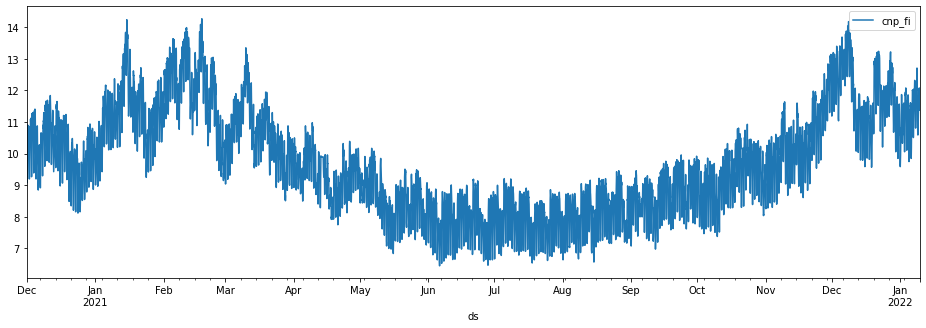

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import os
import logging
import urllib.parse as url
import warnings
import numpy as np

warnings.filterwarnings("ignore")

data_series = [
    'CNPNP',
    'CNPSE', 'CNPSE1', 'CNPSE2', 'CNPSE3', 'CNPSE4',
    'CNPNO', 'CNPNO1', 'CNPNO2', 'CNPNO3', 'CNPNO4', 'CNPNO5',
    'CNPDEN', 'CNPDK1', 'CNPDK2',
    # 'CNPEE', 'CNPLV', 'CNPLT',
    # 'CNPDE', 'CNPNL', 'CNPUK',
    'CNPFI'
]
column_names = [
    'cnp_np',
    'cnp_se', 'cnp_se1', 'cnp_se2', 'cnp_se3', 'cnp_se4',
    'cnp_no', 'cnp_no1', 'cnp_no2', 'cnp_no3', 'cnp_no4', 'cnp_no5',
    'cnp_dk', 'cnp_dk1', 'cnp_dk2',
    # 'cnp_ee', 'cnp_lv', 'cnp_lt',
    # 'cnp_de', 'cnp_nl', 'cnp_uk',
    'cnp_fi'
]

history_start_date = datetime(year=2020, month=12, day=1)
history_end_date = datetime(year=2022, month=1, day=2)
forecast_end_date = datetime(year=2022, month=1, day=9)

request = {
    "series": ','.join(data_series),
    'interval': 'hour',
    'start': history_start_date.strftime('%Y-%m-%d'),
    'end': forecast_end_date.strftime('%Y-%m-%d'),
    'token': '8ycj3jSf2DJZOtX',
    #'token': '7EMf0VCcZxcIdBy',
    'emptydata': 'yes',
    'currency': '',
    'dateFormat': 'nbno',
    'numberFormat': 'nothousandsdot',
    'fileformat': 'csv',
    'headers': 'no'
}

dataUrl = f'https://syspower5.skm.no/api/webquery/execute?{url.urlencode(request)}'
data = pd.read_csv(dataUrl, sep=';', index_col=0, parse_dates=True, dayfirst=True,
                   header=None, names = ['ds'] + column_names).interpolate().reset_index()

data.plot(x='ds', y='cnp_fi', figsize=(16, 5))
data.tail(24)

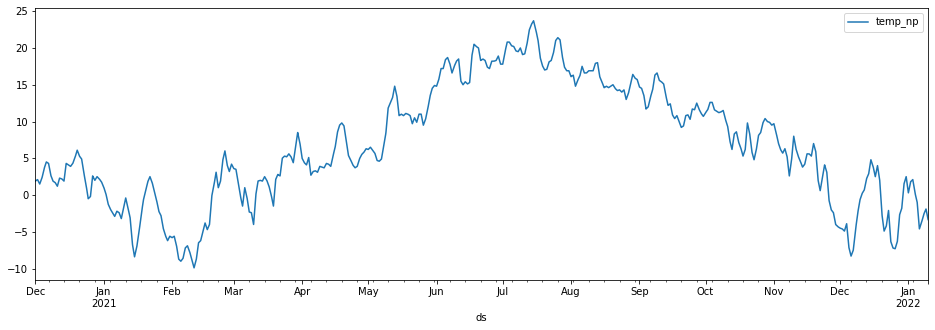

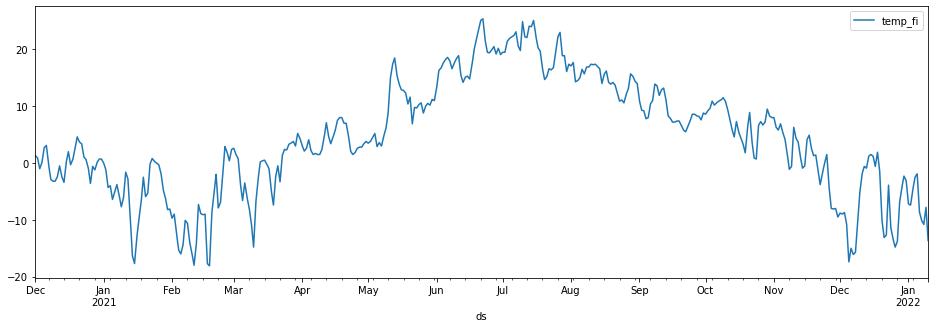

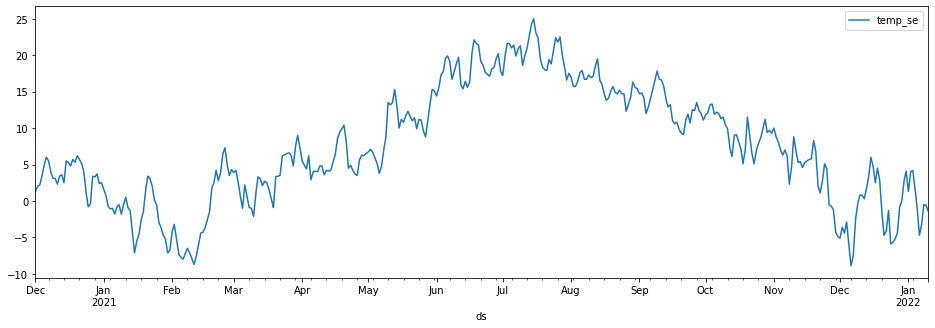

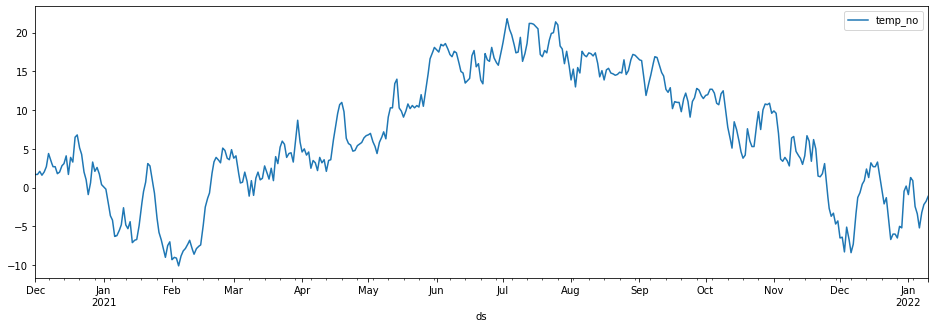

In [5]:
data_series_exog = [
    'SMHITEMPFI_F', 'SMHITEMPSE_F', 'SMHITEMPNO_F', 'SMHITEMPNP_F', 'SMHITEMPDK_F'
]
column_names_exog = [
    'temp_fi', 'temp_se', 'temp_no', 'temp_np', 'temp_dk'
]

temp_date = forecast_end_date + timedelta(days=1)
request = {
    "series": ','.join(data_series_exog),
    'interval': 'day',
    'start': history_start_date.strftime('%Y-%m-%d'),
    'end': temp_date.strftime('%Y-%m-%d'),
    'token': '8ycj3jSf2DJZOtX',
    'emptydata': 'yes',
    'currency': '',
    'dateFormat': 'nbno',
    'numberFormat': 'nothousandsdot',
    'fileformat': 'csv',
    'headers': 'no'
}

dataUrl = f'https://syspower5.skm.no/api/webquery/execute?{url.urlencode(request)}'
temp_data = pd.read_csv(dataUrl, sep=';', index_col=0, parse_dates=True, dayfirst=True,
                        header=None, names = ['ds'] + column_names_exog).interpolate().reset_index()

temp_data['ds'] = pd.to_datetime(temp_data['ds'])
temp_data.set_index('ds', inplace=True)
temp_data = temp_data.resample('H').interpolate()
temp_data = temp_data.reset_index()
temp_data = temp_data[lambda x: x['ds'] < temp_date]
temp_data.plot(x='ds', y='temp_np', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_fi', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_se', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_no', figsize=(16, 5))
data = pd.merge(left=data, right=temp_data, on='ds', how='left')

In [6]:
def create_dataset(df: pd.DataFrame, column_names: list) -> pd.DataFrame:
    result = df.melt(
        id_vars=['ds'],
        value_vars=column_names
    )
    groups_dict = {key: value for value, key in enumerate(column_names)}
    time_idx = np.tile(np.arange(data.shape[0]), len(column_names))
    result['time_idx'] = time_idx
    result['group'] = result.apply(lambda x: groups_dict.get(x['variable'], 0), axis=1)

    result['date'] = result.apply(lambda x: pd.to_datetime(x['ds'].date()), axis=1)
    result['country'] = result.apply(lambda x: x['variable'].split('_')[-1][:2], axis=1)

    special_days = pd.read_excel('syspower_dict.xlsx', 'calendar')
    special_days.columns = ['date', 'country', 'spec_day']
    special_days['country'] = special_days.apply(lambda x: x['country'].lower(), axis=1)
    special_days['spec_day'] = special_days['spec_day'] + 1
    result['weekday'] = result.apply(lambda x: x['ds'].weekday(), axis=1)

    result = pd.merge(left=result, right=special_days, on=['date', 'country'], how='left').fillna(value=0).drop_duplicates().reset_index(drop=True)

    result['day_type'] = result.apply(
        lambda x: 'holiday' if (x['weekday'] == 5 or x['weekday'] == 6 or x['spec_day'] != 0) else 'common',
        axis=1
    )

    result['hour'] = result.apply(lambda x: x['ds'].hour, axis=1).astype(str).astype('category')
    result['weekday'] = result['weekday'].astype(str).astype('category')
    result['month'] = result.apply(lambda x: x['ds'].month, axis=1).astype(str).astype('category')
    result['spec_day'] = result['spec_day'].astype(str).astype('category')

    return result

In [7]:
def add_covariates(df: pd.DataFrame, target_column_names: list) -> pd.DataFrame:
    df_list = [df] * len(target_column_names)
    result_df = pd.concat(df_list, ignore_index=True)
    return result_df

In [8]:
res = create_dataset(df=data, column_names=column_names)
exog_df = add_covariates(df=temp_data, target_column_names=column_names).drop(columns='ds')
res = pd.concat([res, exog_df], axis=1)

In [9]:
res.loc[(res.country == 'fi') & (res.ds == datetime(year=2021, month=12, day=6)), :]

,ds,variable,value,time_idx,group,date,country,weekday,spec_day,day_type,hour,month,temp_fi,temp_se,temp_no,temp_np,temp_dk
154680,2021-12-06,cnp_fi,12.61,8880,15,2021-12-06,fi,0,1.0,holiday,0,12,-15.0,-8.9,-8.4,-8.3,-0.5


In [10]:
#train_data, val_data, test_data = split_dataframe(data=res, train=0.85, val=0.1, test=0.05)

In [11]:
train_data = res[lambda x: x['ds'] < history_end_date]
testing_data = res[lambda x: x['ds'] >= history_end_date]

In [12]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer, MultiNormalizer, EncoderNormalizer
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping

encoder_length = 168
decoder_length = 24

training_cutoff = train_data['time_idx'].max() - decoder_length
training_dataset = TimeSeriesDataSet(
    train_data[lambda x: x.time_idx <= training_cutoff],
    #train_data,
    group_ids=['group'],
    target='value',
    time_idx='time_idx',
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=decoder_length,
    max_prediction_length=decoder_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=column_names_exog,
    time_varying_known_categoricals=['day_type', 'country'],
    #time_varying_known_categoricals=['hour', 'weekday', 'day_type', 'country'],
    target_normalizer=EncoderNormalizer(transformation='log'),
    #add_relative_time_idx=True,
    add_target_scales=True,
    #add_encoder_length=True
    #scalers={'encoder_normalizer': EncoderNormalizer()},
)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    train_data,
    predict=True
)
# test_dataset = TimeSeriesDataSet.from_dataset(
#     training_dataset,
#     test_data
# )
batch_size = 64
train_dataloader = training_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0
)
# test_dataloader = test_dataset.to_dataloader(
#     train=False,
#     batch_size=batch_size,
#     num_workers=0
# )

In [13]:
import pytorch_forecasting as pf
from pytorch_forecasting.metrics import SMAPE, QuantileLoss, LogNormalDistributionLoss
"""
the best params = {'gradient_clip_val': 0.436058692807735, 'hidden_size': 155, 'rnn_layers': 2, 'learning_rate': 0.00997853051614353}; the best value = -1.2212425470352173
"""
model = pf.DeepAR.from_dataset(
    training_dataset,
    hidden_size=40,
    cell_type='LSTM',
    rnn_layers=3,
    learning_rate=1e-3,
    loss=LogNormalDistributionLoss()
)

In [14]:
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     verbose=1
# )
# print(f'the best params = {study.best_trial.params}; the best value = {study.best_value}')

In [15]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=[0] if torch.cuda.is_available() else None,
    weights_summary='top',
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    limit_val_batches=10,
    gradient_clip_val=0.1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


  | Name                   | Type                      | Params
---------------------------------------------------------------------
0 | loss                   | LogNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                | 0     
2 | embeddings             | MultiEmbedding            | 22    
3 | rnn                    | LSTM                      | 35.0 K
4 | distribution_projector | Linear                    | 82    
---------------------------------------------------------------------
35.1 K    Trainable params
0         Non-trainable params
35.1 K    Total params
0.141     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 666


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [17]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = pf.DeepAR.load_from_checkpoint(best_model_path)

In [18]:
# trainer.test(model=best_model, dataloaders=test_dataloader)

In [19]:
# raw_predictions, x = model.predict(val_dataloader, mode='raw', return_x=True)
# for index in range(len(column_names)):
#     best_model.plot_prediction(x, raw_predictions, idx=index, add_loss_to_title=True)

In [20]:
data['cnp_fi_pred'] = 0

dates_range = pd.date_range(
    start=history_end_date + timedelta(hours=decoder_length),
    end=forecast_end_date,
    freq='D'
)
for current_date in dates_range:
    cur_df = res.loc[
             (res['ds'] >= current_date - timedelta(hours=encoder_length+decoder_length)) &
             (res['ds'] < current_date),
             :
        ]
    prediction = best_model.predict(
        cur_df,
        mode='prediction',
        return_x=False
    )
    data.loc[
        (data['ds'] >= current_date - timedelta(hours=decoder_length)) &
        (data['ds'] < current_date),
        'cnp_fi_pred'
    ] = prediction.detach().numpy()[-1, :]

<AxesSubplot:xlabel='ds'>

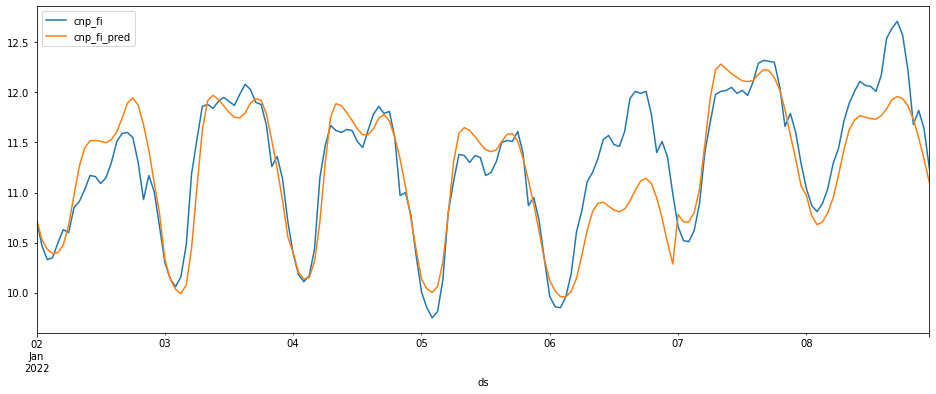

In [21]:
forecast_results = data.loc[
    (data['ds'] >= history_end_date) &
    (data['ds'] < forecast_end_date),
    ['ds', 'cnp_fi', 'cnp_fi_pred']
].set_index('ds')
forecast_results.plot(figsize=(16, 6))

In [22]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(
    y_true=forecast_results.loc[:, 'cnp_fi'],
    y_pred=forecast_results.loc[:, 'cnp_fi_pred']
)
print(f'MAE = {mae}')

MAE = 0.24769897915068126


In [23]:
forecast_results.reset_index(inplace=True)

In [24]:
forecast_results

,ds,cnp_fi,cnp_fi_pred
0,2022-01-02 00:00:00,10.72,10.735111
1,2022-01-02 01:00:00,10.47,10.530042
2,2022-01-02 02:00:00,10.33,10.434356
3,2022-01-02 03:00:00,10.35,10.390821
4,2022-01-02 04:00:00,10.50,10.399785
...,...,...,...
163,2022-01-08 19:00:00,12.22,11.865744
164,2022-01-08 20:00:00,11.68,11.732080
165,2022-01-08 21:00:00,11.82,11.545105
166,2022-01-08 22:00:00,11.64,11.334407


In [25]:
forecast_results['day'] = forecast_results.apply(lambda x: x['ds'].day, axis=1)
forecast_results['hour'] = forecast_results.apply(lambda x: x['ds'].hour, axis=1)
forecast_results['diff'] = forecast_results.apply(lambda x: np.abs(x['cnp_fi'] - x['cnp_fi_pred']), axis=1)
diff = forecast_results.groupby(by='day').max()['diff'].to_numpy()
np.mean(diff * 1000)

613.6008671351841

In [26]:
forecast_results['length'] = encoder_length/decoder_length

In [27]:
forecast_results

,ds,cnp_fi,cnp_fi_pred,day,hour,diff,length
0,2022-01-02 00:00:00,10.72,10.735111,2,0,0.015111,7.0
1,2022-01-02 01:00:00,10.47,10.530042,2,1,0.060042,7.0
2,2022-01-02 02:00:00,10.33,10.434356,2,2,0.104356,7.0
3,2022-01-02 03:00:00,10.35,10.390821,2,3,0.040821,7.0
4,2022-01-02 04:00:00,10.50,10.399785,2,4,0.100215,7.0
...,...,...,...,...,...,...,...
163,2022-01-08 19:00:00,12.22,11.865744,8,19,0.354256,7.0
164,2022-01-08 20:00:00,11.68,11.732080,8,20,0.052080,7.0
165,2022-01-08 21:00:00,11.82,11.545105,8,21,0.274895,7.0
166,2022-01-08 22:00:00,11.64,11.334407,8,22,0.305593,7.0


In [28]:
#forecast_results.to_csv('forecasting_results_deepar.csv', mode='a', header=False)

In [29]:
diff

array([0.74787552, 0.74037975, 0.43952122, 0.31965847, 1.02452892,
       0.27242874, 0.75081345])